In [786]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
# How to use tiktoken: https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

from lxml import etree
from pathlib import Path

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo") # Encoding 'cl100k_base'

In [794]:
with open('data/udhr/udhr_haw.xml') as f:
        tree = etree.parse(f)

tree.getroot().items()

[('iso639-3', 'haw'),
 ('{http://www.w3.org/XML/1998/namespace}lang', 'haw'),
 ('key', 'haw'),
 ('n', 'Hawaiian'),
 ('dir', 'ltr'),
 ('iso15924', 'Latn')]

In [795]:

udhr_dir = Path('data/udhr')
token_dfs = {}
language_names = {}
scripts = {}

def loadUdhrFile(filename):
    with open(filename) as f:
        tree = etree.parse(f)

    text = '\n'.join((lambda x: [x.text] if x is not None else [])(tree.find('{http://www.unicode.org/udhr}title')) + 
        [p.text for p in tree.find('{http://www.unicode.org/udhr}preamble').findall('.//{http://www.unicode.org/udhr}para') if p.text] +
        [p.text for article in tree.findall('{http://www.unicode.org/udhr}article')
                for p in article.findall('.//{http://www.unicode.org/udhr}para') if p.text])

    token_codes = encoding.encode(text)
    df = pd.DataFrame({'decoded': [encoding.decode([token]) for token in token_codes]})
    df['length'] = df['decoded'].str.strip().str.len()
    df['byte_length'] = df['decoded'].apply(lambda d: len(d.strip().encode('utf-8')))

    language_names[language] = tree.getroot().get('n')
    scripts[language] = tree.getroot().get('iso15924')
    return df

for filename in sorted(udhr_dir.glob('*.xml')):
    language = filename.stem[5:]

    print(language, end=' ')

    try:
        df = loadUdhrFile(filename)
        token_dfs[language] = df
        
    except Exception as e:
        print(f"\nError loading {language}: {e}")

afr als arb azj_latn bel ben bre bul cat ceb ces cmn_hans cmn_hant cos cym dan deu_1996 ell_monotonic eng epo est eus fao fin fra fri fur gle glg hat_kreyol hau_3 haw heb hin hrv hsb hun hye ibo ina ind isl ita jav jpn kat kaz kbd khk kir kjh kmr kor lad lat lav lin lit ltz mar mkd mxv nav nds nhn nld nno nob pan pap pcm pes_1 pol por_BR por_PT quc rmy roh ron_2006 run rus sah sco slk slv spa src srp_cyrl srp_latn swe swh tam tel tgk tgl tha tur tyv uig_latn ukr urd uzn_cyrl vec vie wol xho yor ztu zul 

In [798]:
pd.Series(scripts).value_counts()

Latn    76
Cyrl    15
Arab     3
Deva     2
Hans     1
Hant     1
Grek     1
Hebr     1
Beng     1
Armn     1
Jpan     1
Geor     1
Hang     1
Guru     1
Taml     1
Telu     1
Thai     1
dtype: int64

In [789]:
lang = 'haw'
token_dfs[lang][token_dfs[lang]['byte_length'] > 3]['decoded'].apply(lambda s: f"|{s}|").value_counts()[:25]

|’a|        31
|’e|        17
| like|     12
| pale|      9
| mana|      9
| male|      8
|ohana|      7
|lama|       6
| maka|      6
| polit|     3
|upal|       3
|olum|       3
|like|       3
| home|      1
| hele|      1
|aina|       1
|ilik|       1
| union|     1
| make|      1
|elem|       1
|ulan|       1
|’on|        1
|ohon|       1
Name: decoded, dtype: int64

In [790]:
lang_filter = ['spa', 'uig_latn', 'cat', 'tam', 'ind', 'fin', 'als', 'heb', 'kaz',
       'uzn_cyrl', 'fra', 'azj', 'pes', 'ben', 'gle', 'pan', 'lit', 'kor',
       'srp_cyrl', 'hun', 'est', 'tgl', 'arb', 'vie', 'swe', 'tha',
       'cmn_trad', 'isl', 'tgk', 'kir', 'nob', 'cmn_simp', 'tel', 'bul',
       'mkd', 'dan', 'por_BR', 'srp_latn', 'lad', 'deu', 'nld', 'lav',
       'swh', 'ces', 'lat', 'ell', 'nno', 'khk', 'mar', 'rus', 'ita',
       'ukr', 'por_PT', 'hrv', 'cym', 'urd', 'tur', 'pol', 'eng', 'jpn', 'hin']


TokenDistribution = pd.concat([pd.DataFrame({'lang': lang, 'stat': df.drop_duplicates().byte_length.describe()}) 
           for lang, df in token_dfs.items() if lang in lang_filter or True]).reset_index(
           ).set_index(['lang','index']).unstack()['stat'].sort_values('count', ascending=False)

TokenDistributionWithDuplicates = pd.concat([pd.DataFrame({'lang': lang, 'stat': df.byte_length.describe()}) 
           for lang, df in token_dfs.items() if lang in lang_filter or True]).reset_index(
           ).set_index(['lang','index']).unstack()['stat'].sort_values('count', ascending=False)

LongTokenDistribution = pd.concat([pd.DataFrame({'lang': lang, 'stat': df[df.byte_length > 2].drop_duplicates().byte_length.describe()}) 
           for lang, df in token_dfs.items() if lang in lang_filter or True]).reset_index(
           ).set_index(['lang','index']).unstack()['stat'].sort_values('count', ascending=False)


TokenStatsByLanguage = TokenDistribution.join(
    TokenDistributionWithDuplicates, rsuffix='_dup').join(
    LongTokenDistribution, rsuffix='_long')

TokenStatsByLanguage['mean_token_freq'] = TokenStatsByLanguage['count_dup'] / TokenStatsByLanguage['count']

TokenStatsByLanguage.sort_values('count_long')[-25:]

index,25%,50%,75%,count,max,mean,min,std,25%_dup,50%_dup,...,std_dup,25%_long,50%_long,75%_long,count_long,max_long,mean_long,min_long,std_long,mean_token_freq
lang,,,,,,,,,,,,,,,,,,,,,
epo,2.0,3.0,4.0,678.0,9.0,3.205015,0.0,1.389187,2.0,2.0,...,1.191273,3.0,3.0,4.0,480.0,9.0,3.806250,3.0,1.183552,5.429204
pol,2.0,3.0,3.0,783.0,9.0,2.919540,0.0,1.211587,2.0,2.0,...,1.217682,3.0,3.0,4.0,485.0,9.0,3.614433,3.0,0.994716,5.030651
ind,2.0,3.0,4.0,662.0,11.0,3.250755,0.0,1.347590,2.0,3.0,...,1.310116,3.0,3.0,4.0,488.0,11.0,3.788934,3.0,1.134905,5.495468
src,2.0,3.0,4.0,690.0,10.0,3.350725,0.0,1.562962,1.0,2.0,...,1.376789,3.0,4.0,5.0,489.0,10.0,4.018405,3.0,1.352619,6.086957
dan,2.0,3.0,4.0,718.0,13.0,3.188022,0.0,1.422874,2.0,3.0,...,1.323159,3.0,3.0,4.0,502.0,13.0,3.800797,3.0,1.251011,4.628134
sco,3.0,4.0,6.0,653.0,15.0,4.509954,0.0,2.629232,2.0,3.0,...,2.225146,3.0,4.0,7.0,505.0,15.0,5.316832,3.0,2.450019,3.918836
nob,2.0,3.0,4.0,717.0,9.0,3.156206,0.0,1.284037,2.0,3.0,...,1.208291,3.0,3.0,4.0,507.0,9.0,3.721893,3.0,1.079624,4.262204
ron_2006,2.0,3.0,4.0,740.0,11.0,3.451351,0.0,1.721176,2.0,2.0,...,1.418929,3.0,4.0,5.0,511.0,11.0,4.205479,3.0,1.537393,5.271622
pap,3.0,4.0,5.0,671.0,13.0,4.004471,0.0,2.043185,2.0,3.0,...,1.997559,3.0,4.0,6.0,522.0,13.0,4.664751,3.0,1.825566,4.317437


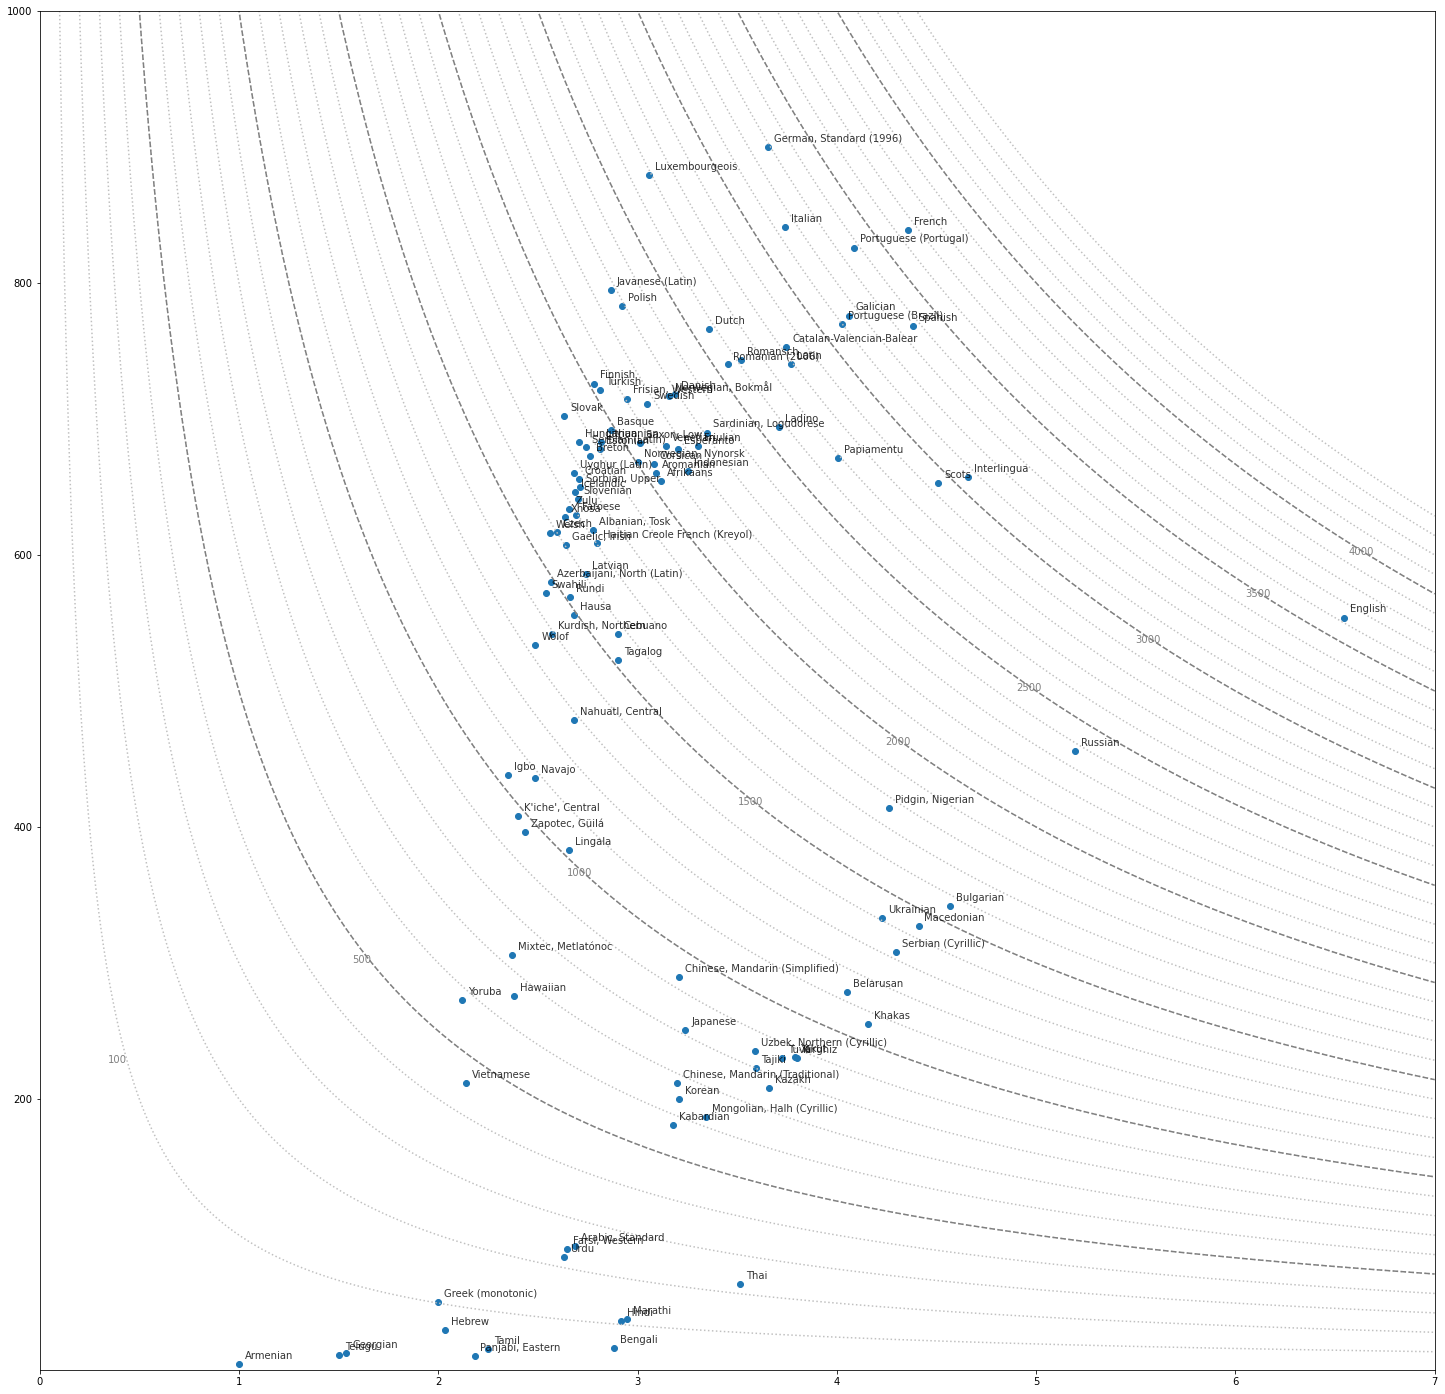

In [791]:
fig, ax = plt.subplots(figsize=(25,25))

ax.scatter(TokenStatsByLanguage['mean'], TokenStatsByLanguage['count'])
ax.set_xlim([0,7])
ax.set_ylim([1, 1000])

for i, code in enumerate(TokenStatsByLanguage.index):
    ax.annotate(language_names[code], (TokenStatsByLanguage['mean'][i] + 0.03, TokenStatsByLanguage['count'][i]+4), alpha=0.8)

x = np.arange(0.001, 8, 0.001)
for param in range(100, 4500, 100):
    ax.plot(x, param/x, color='silver', ls=':')
for param in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]:
    ax.plot(x, param/x, color='grey', ls='--')


N = np.asarray([100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
x = (np.sqrt(40000 + N * 240) - 200) / 120
y = N / x

for i in range(len(N)):
    ax.annotate(str(N[i]), (x[i] - 0.1, y[i]), color='grey')




In [792]:
500 / np.arange(0, 8, 0.001)

/var/folders/g7/8vxyyp0n0sz9vxw2bpxdd4jc0000gn/T/ipykernel_33799/1626100401.py:1: RuntimeWarning: divide by zero encountered in true_divide
  500 / np.arange(0, 8, 0.001)


array([           inf, 5.00000000e+05, 2.50000000e+05, ...,
       6.25234463e+01, 6.25156289e+01, 6.25078135e+01])

In [793]:
(lambda df:df[df['byte_length'] > 13])(token_dfs['rus'])

,decoded,length,byte_length
249,обходим,7,14
349,обходим,7,14
648,значение,8,16
2339,использов,9,18
3346,обходим,7,14
3635,обходим,7,14
3824,обходим,7,14
3836,который,7,14
3838,обходим,7,14
4461,результат,9,18
